In [1]:
# TODO: fix last dense layer. Is it the number of classes? If so then nothing to fix
# TODO: discuss how reading in dataset could be made multi-threaded (each dataset is read in on own thread then all joined together at the end)

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import re
from datetime import datetime
import collections

In [2]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [3]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus[0])
# tf.config.experimental.set_memory_growth(gpus[0], True)

# Read in dataset

* first argument is the `using_batch_generator` flag
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [5]:
%run readInDataset.py true 20160724_July 20160829_August

args: ['readInDataset.py', 'true', '20160724_July', '20160829_August']
using_batch_generator? True
dataset_names: ['20160724_July', '20160829_August']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames length: 230
done current subset
readi

In [6]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

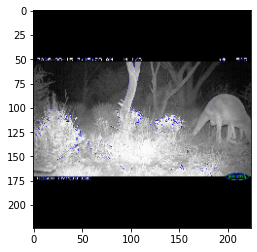

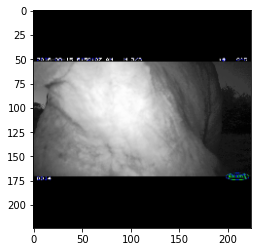

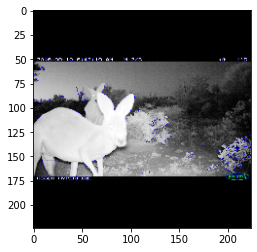

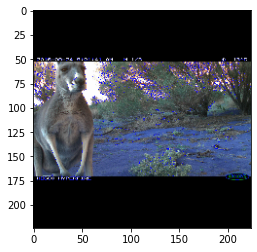

In [7]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(training_images[0])
displayImage(training_images[10])
displayImage(training_images[100])
displayImage(training_images[1000])

# `training_images` and `test_images` will correspond to filenames if `using_batch_generator` is set to true
training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

## Train the model

In [8]:
model = tf.keras.models.Sequential([                                    
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dense(len(classes), activation='softmax')#FIXME is this the number of classes? (check paper)
])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
    factor=0.1, patience=1, \
    min_lr=0.00001)

model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=90,
          callbacks=[reduce_lr])

2022-06-03 13:03:55.752103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:03:55.757142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:03:55.757328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Epoch 1/90


2022-06-03 13:03:55.758137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 13:03:55.758555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:03:55.758707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 13:03:55.758842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

89/89 [==============================] - 19s 178ms/step - loss: 1.2271 - accuracy: 0.6273 - top_k_categorical_accuracy: 0.9845 - val_loss: 0.9541 - val_accuracy: 0.6661 - val_top_k_categorical_accuracy: 0.9873 - lr: 0.0100
Epoch 2/90
89/89 [==============================] - 14s 159ms/step - loss: 0.9241 - accuracy: 0.6670 - top_k_categorical_accuracy: 0.9915 - val_loss: 0.9206 - val_accuracy: 0.6780 - val_top_k_categorical_accuracy: 0.9870 - lr: 0.0100
Epoch 3/90
89/89 [==============================] - 15s 163ms/step - loss: 0.8624 - accuracy: 0.6801 - top_k_categorical_accuracy: 0.9936 - val_loss: 0.8171 - val_accuracy: 0.7104 - val_top_k_categorical_accuracy: 0.9933 - lr: 0.0100
Epoch 4/90
89/89 [==============================] - 15s 163ms/step - loss: 0.7858 - accuracy: 0.7148 - top_k_categorical_accuracy: 0.9937 - val_loss: 0.7932 - val_accuracy: 0.7286 - val_top_k_categorical_accuracy: 0.9916 - lr: 0.0100
Epoch 5/90
89/89 [==============================] - 14s 162ms/step - loss: 

## Evaluate the trained model

In [9]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)

test_images shape: (3556, 224, 224, 3)
test_labels shape: (3556, 10)


2022-06-03 13:26:21.631142: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.
2022-06-03 13:26:21.842044: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 2s 16ms/step - loss: 0.1994 - accuracy: 0.9424 - top_k_categorical_accuracy: 0.9983


In [10]:
predictions = (model.predict(test_images) > 0.5).astype("int32")
# print("Predictions (shape: {}):\n{}".format(predictions.shape, predictions))

2022-06-03 13:26:24.000800: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.
2022-06-03 13:26:24.206038: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 2s 14ms/step


In [11]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Emu', 'Kangaroo', 'Human Presense/Deployment', 'Empty photo', 'Fox', 'Other', 'Rabbit', 'Bird', 'Cat', 'Dog']
train classes count: Counter({'Kangaroo': 2347, 'Empty photo': 626, 'Emu': 254, 'Human Presense/Deployment': 208, 'Fox': 64, 'Cat': 32, 'Rabbit': 13, 'Bird': 6, 'Other': 5, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       1.00      0.17      0.29         6
                      Cat       0.92      0.38      0.53        32
                      Dog       0.00      0.00      0.00         1
              Empty photo       1.00      0.99      0.99       626
                      Emu       0.86      0.89      0.87       254
                      Fox       0.82      0.36      0.50        64
Human Presense/Deployment       0.84      0.67      0.74       208
                 Kangaroo       0.96      0.98      0.97      2347
                    Other       0.00      0.00      0.00         5
                   

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [12]:
now = datetime.now()
dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
print("saving model as: 'ZFNet-{}.h5'.'".format(dt_string))

model.save('saved_models/ZFNet-{}.h5'.format(dt_string))

saving model as: 'ZFNet-03-06-2022_13:26:26.h5'.'


2022-06-03 13:26:26.067091: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.


## Free up the GPU's memory

In [13]:
cuda.select_device(0)
cuda.close()